<a href="https://colab.research.google.com/github/ekokrek/nCD8T_deregComplexes/blob/main/Thomson23_nCD8T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Correction on nCD8T cells

Batch correction on three age groups: Child, YAdult, OAdult

## Part I
1. Install Required Packages
2. Merge sample-specific expression data into one cell-type specific dataset


In [ ]:
!pip install scanpy h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=e36826e1cf1dc1e8866a67bffa8e93a6bef3a8324fde45561717c2d75aaabf30
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=85af7742f6e47b91e004a02b9602712a466a7e93f5e9eabc2c6790e663f17ac0
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9

In [ ]:
!pip install scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.2 MB/s eta 0:00:00


In [ ]:
!pip install typing-extensions==4.5.0

In [ ]:
!pip install kaleido

In [ ]:
!pip install --upgrade fastapi tensorflow-probability typing-extensions

In [ ]:
!pip install git+https://github.com/theislab/scgen.git

  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-hir8zx25
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-hir8zx25
  Resolved https://github.com/theislab/scgen.git to commit d79e1f04233c30f9a4eb5b8d57718127909807d7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import scgen

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [ ]:
import pandas as pd
import scanpy as sc
import h5py
import gc
import seaborn as sns
import numpy as np

In [ ]:
# Read the metadata CSV file
metadata = pd.read_csv('/content/drive/MyDrive/Thomson23/Thomson23_dataset.csv')

# Initialize an empty AnnData object for the merged dataset
merged_dataset = None

# define cType
cType = 'CD8 Naive'

In [ ]:
for i, row in metadata.iterrows():
    file_path = row['FileName']
    adata = sc.read_10x_h5("/content/drive/MyDrive/Thomson23/rawD/{0}".format(file_path))
    adata.var_names_make_unique()

    # Read additional data from the h5 file
    with h5py.File("/content/drive/MyDrive/Thomson23/rawD/{0}".format(file_path), 'r') as f:
        cell_types_bytes = f['/matrix/observations/seurat_pbmc_type'][()]
        cell_types = [ct.decode('utf-8') for ct in cell_types_bytes]

    # Add metadata to AnnData
    adata.obs["cell_type"] = cell_types
    adata.obs["age_group"] = metadata['AgeGroup'][i]
    adata.obs["sample_id"] = metadata['SampleID'][i]
    adata.obs["sex"] = metadata['Sex'][i]

    # Extract batch information from the Title column and add it to adata.obs
    title = metadata['Title'][i]
    batch = title.split('_')[-1]  # This splits the title by underscores and takes the last part
    adata.obs["batch"] = batch

    # Filter by specific cell type if necessary
    adata = adata[adata.obs['cell_type'] == cType]

    # If merged_dataset is None, initialize it with the first adata
    if merged_dataset is None:
        merged_dataset = adata
    else:
        # Concatenate adata with the merged_dataset
        merged_dataset = sc.concat([merged_dataset, adata], join='outer')

    # Optional: Handle memory explicitly (e.g., delete adata or call gc.collect())
    del adata
    gc.collect()


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_name

In [ ]:
merged_dataset

AnnData object with n_obs × n_vars = 69095 × 33538
    obs: 'cell_type', 'age_group', 'sample_id', 'sex', 'batch'

In [ ]:
from scipy.sparse import csr_matrix
merged_dataset.X = csr_matrix(merged_dataset.X)

In [ ]:
merged_dataset.write_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T.h5ad')

## Part II
1. QC on merged dataset
2. PCA - kNN - UMAP

In [ ]:
adata = sc.read_h5ad("/content/drive/MyDrive/Thomson23/data/nCD8T.h5ad")

In [ ]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

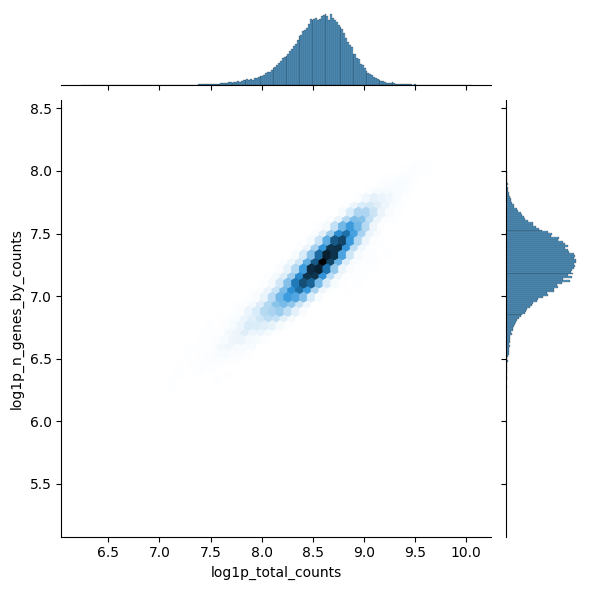

In [ ]:
sns.jointplot(
    data=adata.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

<Axes: xlabel='pct_counts_mito', ylabel='Count'>

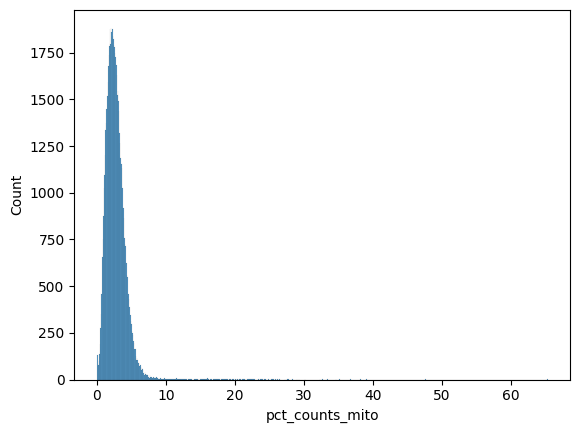

In [ ]:
sns.histplot(adata.obs["pct_counts_mito"])

In [ ]:
sc.pp.highly_variable_genes(adata,n_top_genes=7000,flavor="seurat_v3")

In [ ]:
sum(adata.var['highly_variable'])

7000

In [ ]:
adata.X = adata.X.astype(np.float32)
sc.tl.pca(adata, svd_solver='arpack')

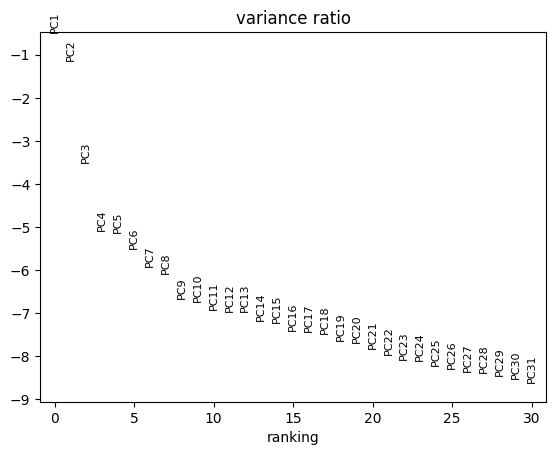

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

In [ ]:
sc.tl.umap(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'age_group'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sample_id'}, xlabel='UMAP1', ylabel='UMAP2'>]

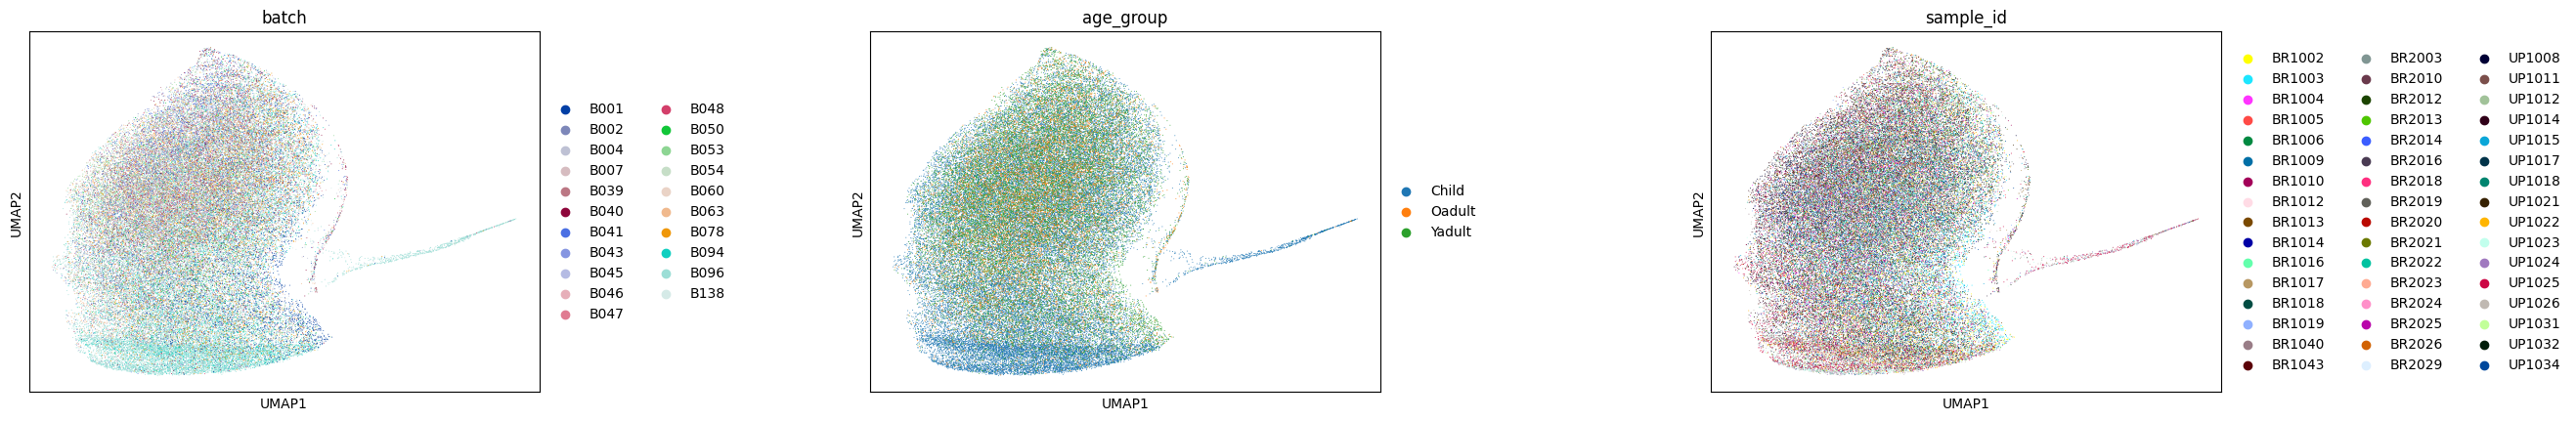

In [ ]:
sc.pl.umap(adata, color=["batch","age_group","sample_id"], wspace=.5, show=False)

In [ ]:
adata.write_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_processed.h5ad')

## Part III
1. AnnData setup
2. model training
3. model saving

In [ ]:
import pandas as pd
import scanpy as sc
import scgen
import numpy as np

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [ ]:
train = sc.read_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_processed.h5ad')

In [ ]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="cell_type")

In [ ]:
model = scgen.SCGEN(train)
model.save("/content/drive/MyDrive/Thomson23/saved_models/model_batch_removal",prefix="model_nCD8T",save_anndata=True, overwrite=True)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=10,
    early_stopping=True,
    early_stopping_patience=25,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 27/100:  27%|██▋       | 27/100 [41:14<1:51:31, 91.66s/it, v_num=1, train_loss_step=8.18e+3, train_loss_epoch=8.33e+3]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 28793.066. Signaling Trainer to stop.


In [ ]:
model.save("/content/drive/MyDrive/Thomson23/saved_models/model_batch_removal",prefix="model_nCD8T",save_anndata=True, overwrite=True)

## Part IV
1. Batch correction
2. PCA - kNN - UMAP

In [ ]:
model = scgen.SCGEN.load("/content/drive/MyDrive/Thomson23/saved_models/model_batch_removal/",prefix="model_nCD8T")

INFO     File /content/drive/MyDrive/Thomson23/saved_models/model_batch_removal/model_nCD8Tmodel.pt already        
         downloaded                                                                                                


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
model

SCGEN Model with the following params: 
n_hidden: 800, n_latent: 100, n_layers: 2, dropout_rate: 0.2
Training status: Trained
Model's adata is minified?: False

In [ ]:
adata=sc.read_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_processed.h5ad')

In [ ]:
adata = adata[adata.obs['age_group'] == 'Oadult']

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 8541 × 33538
    obs: 'cell_type', 'age_group', 'sample_id', 'sex', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'age_group_colors', 'batch_colors', 'hvg', 'neighbors', 'pca', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
adata = adata.copy()

In [ ]:
scgen.SCGEN.setup_anndata(adata, batch_key="batch", labels_key="cell_type")

In [ ]:
corrected_adata = model.batch_removal(adata)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/usr/local/lib/python3.10/dist-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(
/usr/local/lib/python3.10/dist-packages/scgen/_scgen.py:287: ImplicitModificationWarning: Setting element `.obsm['latent']` of view, initializing view as actual.
  corrected.obsm["latent"] = all_shared_ann[corrected.obs_names,:].X


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
corrected_adata

AnnData object with n_obs × n_vars = 8541 × 33538
    obs: 'cell_type', 'age_group', 'sample_id', 'sex', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [ ]:
corrected_adata.write_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_Oadult_corrected.h5ad')

## Part V
1. Merging the corrected data
2. QC metrics ?
2. PCA - kNN - UMAP

In [ ]:
merged_corrected=sc.read_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_child_corrected.h5ad')

In [ ]:
adata = sc.read_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_yadult_corrected.h5ad')

In [ ]:
merged_corrected = sc.concat([merged_corrected, adata], join='outer')


In [ ]:
adata = sc.read_h5ad('/content/drive/MyDrive/Thomson23/data/nCD8T_oadult_corrected.h5ad')

In [ ]:
merged_corrected = sc.concat([merged_corrected, adata], join='outer')

In [ ]:
merged_corrected

AnnData object with n_obs × n_vars = 69095 × 33538
    obs: 'cell_type', 'age_group', 'sample_id', 'sex', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', '_scvi_batch', '_scvi_labels'
    obsm: 'corrected_latent', 'latent'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


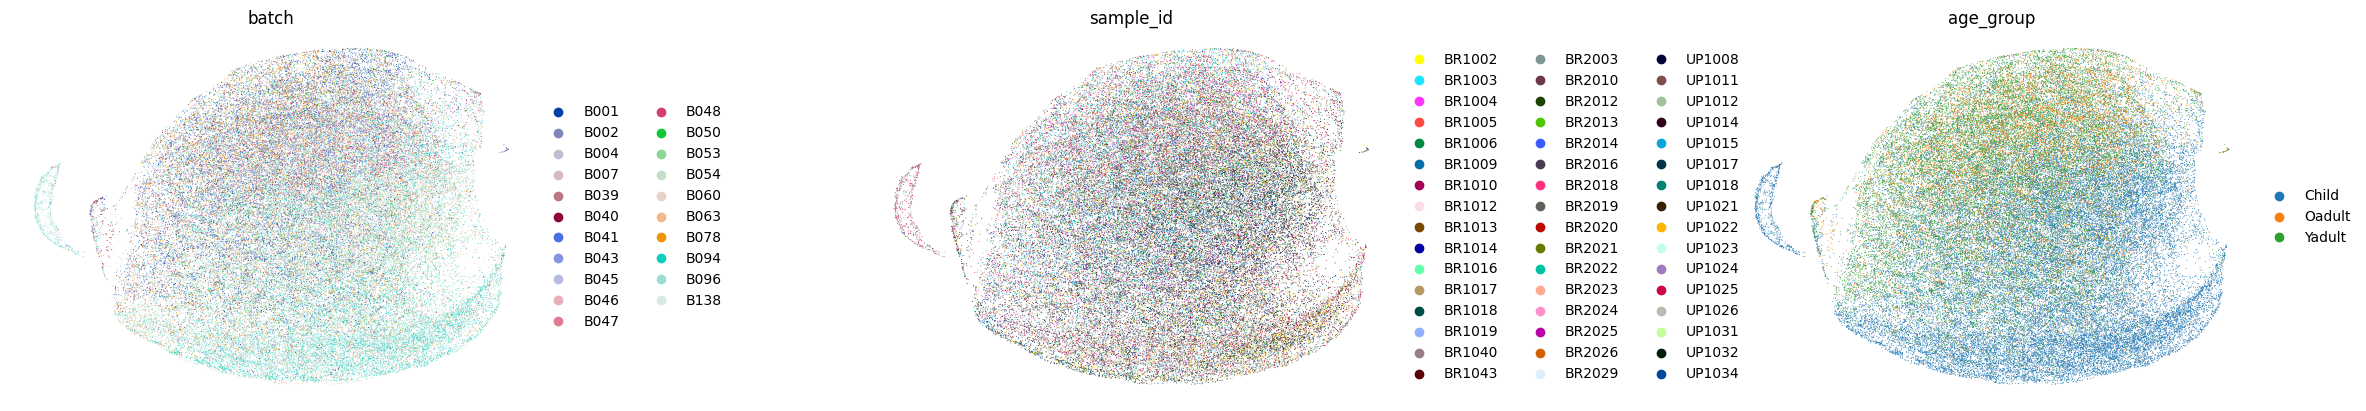

In [ ]:
#sc.pp.neighbors(merged_corrected)
#sc.tl.umap(merged_corrected)
sc.pl.umap(merged_corrected, color=['batch','sample_id', 'age_group'], wspace=0.5, frameon=False)

In [ ]:
merged_corrected

AnnData object with n_obs × n_vars = 69095 × 33538
    obs: 'cell_type', 'age_group', 'sample_id', 'sex', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap', 'batch_colors', 'sample_id_colors', 'cell_type_colors', 'age_group_colors'
    obsm: 'corrected_latent', 'latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


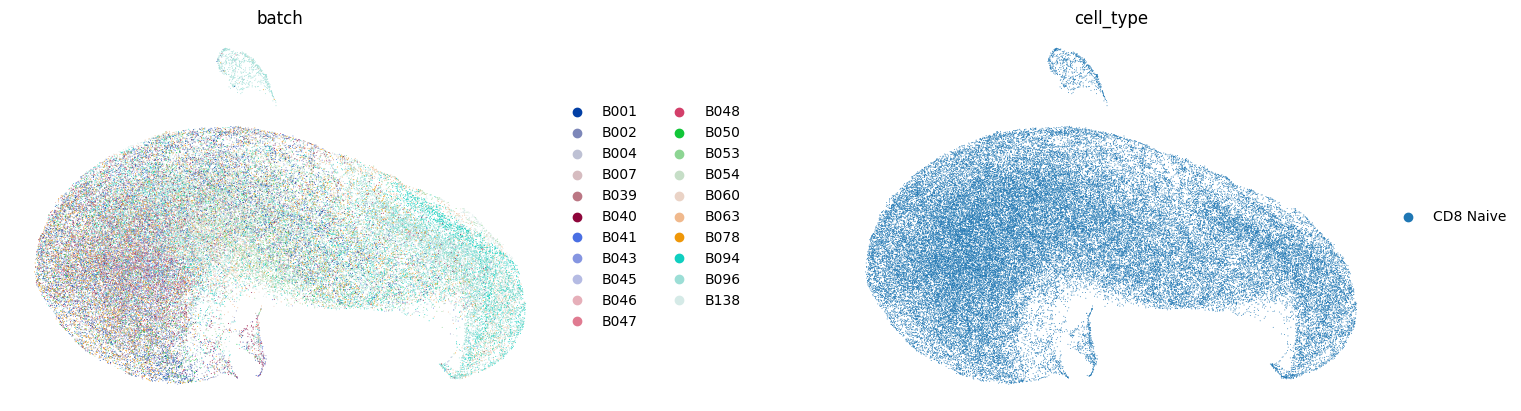

In [ ]:
sc.pp.neighbors(merged_corrected, use_rep="corrected_latent")
sc.tl.umap(merged_corrected)
sc.pl.umap(merged_corrected, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

## Part VI
Generating single sample-specific expression files continues on another notebook